In [3]:
!conda install -c conda-forge Quandl --yes 
print("complete")

Solving environment: ...working... 
  - anaconda::ca-certificates-2019.1.23-0, anaconda::openssl-1.1.1b-he774522_1
  - anaconda::ca-certificates-2019.1.23-0, defaults::openssl-1.1.1b-he774522_1
  - anaconda::openssl-1.1.1b-he774522_1, defaults::ca-certificates-2019.1.23-0
  - defaults::ca-certificates-2019.1.23-0, defaults::openssl-1.1.1b-he774522_1done

# All requested packages already installed.

complete


In [2]:
import pandas as pd
import quandl,math, datetime
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import figure
import pickle

style.use('ggplot')

df = quandl.get('WIKI/GOOGL')

df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = ((df['Adj. High']-df['Adj. Close'])/ df['Adj. Close']) * 100.0
df['HL_change'] = ((df['Adj. Close']-df['Adj. Open'])/ df['Adj. Open']) * 100.0

df = df[['HL_change','HL_PCT','Adj. Close','Adj. Volume']] # Features
forecast_col = 'Adj. Close' # Target
df.fillna(-99999, inplace=True) # Replace null with outlier.  Droping NAs can damage model

forecast_out = int(math.ceil(.01*len(df))) # Number of days you want to forecast out. Takes num of days of data multiplied by percentage of choice
print("Forecast out: " + str(forecast_out) + " days")

#print(forecast_out)
df['label'] = df[forecast_col].shift(-forecast_out) # Shift label column by that many days. Now we have our close, and our target example label, which is what we want to predict
df.dropna(inplace=True)
df.head(10)

Forecast out: 35 days


,HL_change,HL_PCT,Adj. Close,Adj. Volume,label
Date,,,,,
2004-08-19,0.324968,3.712563,50.322842,44659000.0,69.078238
2004-08-20,7.227007,0.710922,54.322689,22834300.0,67.839414
2004-08-23,-1.227880,3.729433,54.869377,18256100.0,68.912727
2004-08-24,-5.726357,6.417469,52.597363,15247300.0,70.668146
2004-08-25,1.183658,1.886792,53.164113,9188600.0,71.219849
2004-08-26,2.820391,0.037068,54.122070,7094800.0,72.278116
2004-08-27,-1.803885,2.326896,53.239345,6211700.0,74.810934
2004-08-30,-3.106003,3.411430,51.162935,5196700.0,74.199045
2004-08-31,0.048866,1.308977,51.343492,4917800.0,70.462511


In [3]:
# Define X and y.
X = np.array(df.drop(['label'],1)) # convert df features to an array. ignoring the label column
X = preprocessing.scale(X) # Scaling X before we feed it through the classifier
X_predict = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True) # Drop na values
y = np.array(df['label']) # converts the values of Label to an array
y = y[:-forecast_out]
print(len(X),len(y)) # Ensure that the arrays are the same length

# Select and Train Model
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
#clf = svm.SVR(kernel='poly') # Select classifier

''' Define CLF, train model '''
# clf = LinearRegression(n_jobs=-1) # n_jobs=-1 says to use all of the processeing power available
# clf.fit(X_train, y_train) # Fit our training data

''' What is Pickling?  Pickling is serialization of any python object. 
Dictionary, classifier, etc.  Allows you to avoid re-training the data set.  
Notice clf is no longer required to be defined'''
# with open('linearregression.pickle', 'wb') as f:
    # pickle.dump(clf,f)
    
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test) # score our testing data. With Linear Regression, Accuracy is squared error

print(accuracy)
print("Complete")

3354 3354
0.9781709858449016
Complete


[1081.48213646 1096.06460435 1110.05656423 1104.71695758 1098.25118696
 1095.58012709 1093.88561842 1090.83361833 1084.74813763 1080.37573515
 1077.94803124 1097.5689533  1116.12601994 1120.69335228 1135.58430051
 1139.65168342 1138.29148152 1135.72373007 1137.5242426  1156.02365526
 1155.54131368 1165.24280566 1161.88882098 1169.62954089 1190.13311543
 1202.56327244 1197.08797651 1208.83585838 1214.37131868 1212.67472561
 1203.35878253 1208.81215704 1207.50853781 1142.86487146 1090.20916666] 0.9781709858449016 35


<function matplotlib.pyplot.show(*args, **kw)>

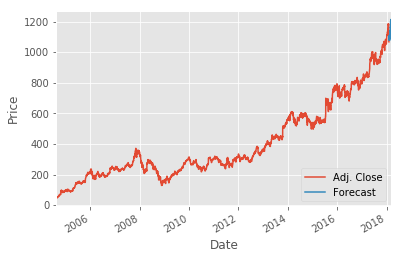

In [4]:
# Forecast
forecast_set = clf.predict(X_predict)
print(forecast_set, accuracy, forecast_out)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name # select last date in dataframe
last_unix = last_date.timestamp()
one_day = 86400 # Seconds in a day
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix) # Add one day
    next_unix += one_day # Increment next_unix
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] # At the index of next_date,
    # replace all values in that row with NaN, since this is the forecasted info. Then append i,
    # which is the value forecasted

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.rcParams["figure.figsize"] = (10,10)
plt.show

In [5]:
df.tail(50)

,HL_change,HL_PCT,Adj. Close,Adj. Volume,label,Forecast
Date,,,,,,
2018-01-16 00:00:00,-0.842753,1.607854,1130.70,1783881.0,1115.04,NaN
2018-01-17 00:00:00,0.241121,0.019313,1139.10,1353097.0,1129.38,NaN
2018-01-18 00:00:00,-0.296660,0.406701,1135.97,1333633.0,1160.84,NaN
2018-01-19 00:00:00,0.480655,0.024486,1143.50,1418376.0,1165.93,NaN
2018-01-22 00:00:00,1.778252,0.233645,1164.16,1437954.0,1139.91,NaN
2018-01-23 00:00:00,0.474108,0.198951,1176.17,1832126.0,1148.89,NaN
2018-01-24 00:00:00,-1.155294,1.345525,1171.29,1818182.0,1150.61,NaN
2018-01-25 00:00:00,0.121114,0.241934,1182.14,1398961.0,1134.42,NaN
2018-01-26 00:00:00,0.002526,0.000000,1187.56,1981476.0,1100.07,NaN


In [ ]:
# List Example to show what's happening
List = ['G','E','E','K','S','F', 
        'O','R','G','E','E','K','S'] 
#print("Initial List: ") 
#print(List) 
Sliced_List = List[-6:] 
#print("\nElements sliced till 6th element from last: ") 
#print(Sliced_List) 

for i in range(len(List)):
    print(List[i])
